Préparation des données


In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

products = pd.read_csv('/content/drive/MyDrive/flipkart_com-ecommerce_sample_1050.csv')

pd.set_option("display.max_colwidth", None)

label_encoder = LabelEncoder()


In [2]:
# Build generic dataset with image, text and label
data = (products
        .loc[:, ["product_category_tree", "image", "description"]]
        .assign(
            categories = lambda df_: (df_
                                      .product_category_tree
                                      .str.strip("[]")
                                      .str.split(" >> ")
                                      .map(lambda l: l[0])
                                      .str.strip('"')
                                      ),
            text = lambda df_: df_.description.str.strip(),
            label = lambda df_: label_encoder.fit_transform(df_.categories)
        )
        .drop(columns=["description", "product_category_tree"])
        )

In [3]:
data.to_csv("data.csv", index=False)

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

NB_CLASSES = len(label_mapping)

In [4]:
!pip install datasets transformers
from datasets import Dataset
import tensorflow as tf
from transformers import (AutoTokenizer,
                          DataCollatorWithPadding,
                          TFAutoModelForSequenceClassification,
                          Trainer,
                          TrainingArguments)

In [5]:
MODEL_NAME = "distilbert-base-cased"

data_text = data.drop(columns=["image", "categories"])

text_dataset = Dataset.from_pandas(data_text)

# Train/Eval Split
splits = text_dataset.train_test_split(test_size=0.2, seed=42)

text_train = splits["train"]
text_eval = splits["test"]

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)

text_train = text_train.map(tokenize_function, batched=True)
text_eval = text_eval.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_text_train = text_train.to_tf_dataset(
    columns = ["input_ids", "attention_mask", "label"],
    shuffle = False,
    batch_size = 16,
    collate_fn = data_collator
)

tf_text_eval = text_eval.to_tf_dataset(
    columns = ["input_ids", "attention_mask", "label"],
    shuffle = False,
    batch_size = 16,
    collate_fn = data_collator,
)

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

In [7]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NB_CLASSES
    )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [8]:
# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [tf.metrics.SparseCategoricalAccuracy()],
)

model.summary()

# Train the model
model.fit(
    tf_text_train,
    validation_data = tf_text_eval,
    epochs = 3,
)

model.save('text_model.keras')

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  65190912  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 65786887 (250.96 MB)
Trainable params: 65786887 (250.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
53/53 [=============================

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)



Créer un modèle basé uniquement sur les images des produits


In [9]:
df = pd.read_csv('data.csv')
df



,image,categories,text,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,Specifications of Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Bath Towel Features Material Cotton Terry Design SHUVAM General Brand Eurospa GSM 360 Type Face Towel Set Model Name SHUVAM20PCFTSETASSORTED Ideal For Boys, Girls, Men, Women Model ID SHUVAM20PCFTSETASSORTED Size small Color Assorted Dimensions Weight 350 g Length 9 inch Width 9 inch In the Box Number of Contents in Sales Package 20 Sales Package 20 PIECE FACE TOWEL SET",0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,"Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet Perfact for Wedding & Gifting,Specifications of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet (1 Bedsheet,2 Pillow Cover, Multicolor) General Brand SANTOSH ROYAL FASHION Machine Washable Yes Type Flat Material Cotton Model Name Gold Design Royal Cotton Printed Wedding & Gifted Double Bedsheet With 2 Pillow cover Model ID goldbedi-38 Color Multicolor Size King Fabric Care Machine Wash, Do Not Bleach Dimensions Flat Sheet Width 90 inch / 230 cm Fitted Sheet Width 228 cm Pillow Cover Width 16 inch / 43 cm Pill

Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/27 ━━━━━━━━━━━━━━━━━━━━ 4:30 23s/step - accuracy: 0.2359 - loss: 1.9231

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 901s 25s/step - accuracy: 0.3033 - loss: 1.7941 - val_accuracy: 0.3857 - val_loss: 1.6417
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 694ms/step - accuracy: 0.6923 - loss: 1.0715 - val_accuracy: 0.4714 - val_loss: 1.4707
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 693ms/step - accuracy: 0.7047 - loss: 0.8876 - val_accuracy: 0.4714 - val_loss: 1.3972
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 723ms/step - accuracy: 0.7221 - loss: 0.8530 - val_accuracy: 0.4905 - val_loss: 1.3760
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 724ms/step - accuracy: 0.7769 - loss: 0.7027 - val_accuracy: 0.4381 - val_loss: 1.5110
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 720ms/step - accuracy: 0.7857 - loss: 0.6560 - val_accuracy: 0.4762 - val_loss: 1.4883
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 733ms/step - accuracy: 0.7799 - loss: 0.6588 - val_accuracy: 0.4667 - val_loss: 1.4773
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 723ms/step - accuracy: 0.7786 - loss: 0.6448 - val_accuracy: 0.4857

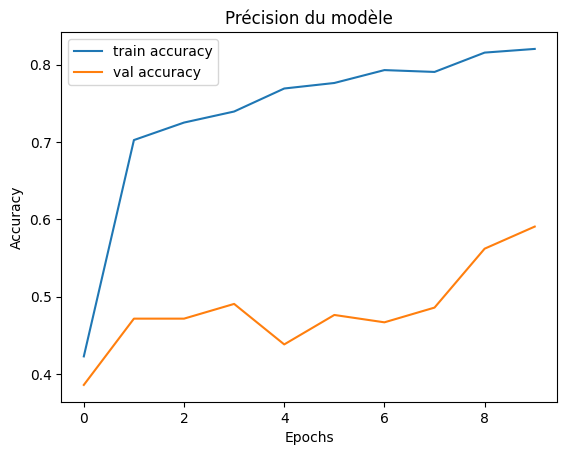

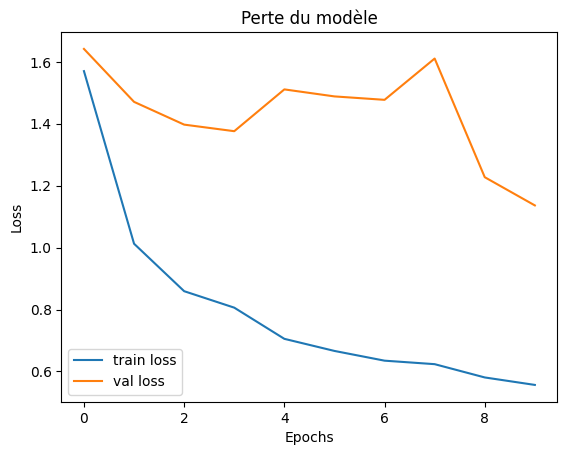

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Charger les données pré-traitées
data = pd.read_csv("data.csv")

# Générer les labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['categories'])
data['label_str'] = data['label'].astype(str)  # Convertir les étiquettes en chaînes de caractères

NB_CLASSES = len(label_encoder.classes_)

# Générateur d'images
datagen = ImageDataGenerator(
    validation_split=0.2,  # Utiliser 20% pour la validation
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Création des générateurs pour les images
train_gen = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/content/drive/MyDrive/Images_market',  # Remplacez par le chemin vers le dossier d'images
    x_col='image',
    y_col='label_str',  # Utilisation de la colonne des étiquettes en chaîne de caractères
    target_size=(224, 224),  # Adapter à la taille d'entrée du modèle choisi
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/content/drive/MyDrive/Images_market',
    x_col='image',
    y_col='label_str',  # Utilisation de la colonne des étiquettes en chaîne de caractères
    target_size=(224, 224),
    class_mode='categorical',
    subset='validation'
)

# Charger le modèle VGG16 pré-entraîné
image_input = Input(shape=(224, 224, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(NB_CLASSES, activation='softmax')(x)

# Définir le modèle
model_img = Model(inputs=image_input, outputs=predictions)

# Geler les couches du modèle de base (VGG16)
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model_img.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
history = model_img.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

# Sauvegarder le modèle
model_img.save('image_model.keras')

# Afficher les résultats de l'entraînement
import matplotlib.pyplot as plt

# Courbe de précision
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Précision du modèle')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Courbe de perte
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Perte du modèle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Charger le modèle sauvegardé
model_load = tf.keras.models.load_model('image_model.keras')

In [12]:
# Chemin vers la nouvelle image
image_path = "/content/drive/MyDrive/Images_market/0096e89cc25a8b96fb9808716406fe94.jpg"

# Charger et prétraiter l'image
img = image.load_img(image_path, target_size=(224, 224))  # Redimensionner à la taille d'entrée du modèle
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour le batch
img_array = img_array / 255.0  # Normaliser les valeurs des pixels

In [13]:
# Prédire la classe de l'image
prediction = model_load.predict(img_array)

# Obtenir l'index de la classe prédite
predicted_class_index = np.argmax(prediction)

# Obtenir le nom de la classe prédite
# Assurez-vous que label_encoder est défini et accessible
predicted_class_name = label_encoder.inverse_transform([predicted_class_index])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


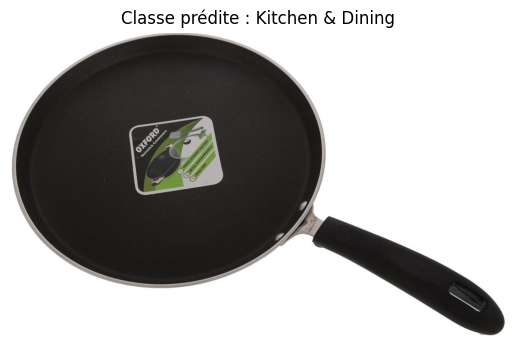

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Afficher l'image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Masquer les axes

# Afficher la classe prédite en tant que titre
plt.title("Classe prédite : " + predicted_class_name)

plt.show()

Multi inputs model



In [15]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Concatenate, Input, Embedding, LSTM, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# **1. Préparation des Données d'Image**
# Dossier contenant les images
image_dir = "/content/drive/MyDrive/Images_market"
image_size = (224, 224)  # Taille d'entrée pour VGG16
image_data = []  # Liste pour stocker les images

# Charger les images et les préparer
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(image_dir, filename)
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0  # Normalisation entre 0 et 1
        image_data.append(img_array)

# Convertir en tableau NumPy
image_data = np.array(image_data)

# **2. Préparation des Données Textuelles**
# Charger le fichier CSV
df = pd.read_csv("data.csv")

# Vérifier les colonnes disponibles dans le CSV pour s'assurer du bon nom de colonne pour les labels
print("Colonnes disponibles dans le CSV :", df.columns)

# Extraire les textes
texts = df['text'].astype(str).tolist()

# Initialiser le Tokenizer
vocab_size = 10000  # Taille du vocabulaire
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Convertir les textes en séquences et appliquer le padding
text_sequences = tokenizer.texts_to_sequences(texts)
max_length = 100  # Longueur max de chaque séquence
text_padded = pad_sequences(text_sequences, maxlen=max_length, padding='post', truncating='post')

# **3. Préparation des Labels**
# Mapper les labels textuels en indices numériques
unique_labels = df['categories'].unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
labels = df['categories'].map(label_mapping).values
labels = labels.astype(int)  # Conversion en type entier

# Vérification de la conversion
print("Mapping des labels :", label_mapping)
print("Exemple de labels après conversion :", labels[:10])  # Vérifiez les valeurs
print("Type de labels :", labels.dtype)

# **4. Définition du Modèle Multi-Input**
# Modèle pour les images (VGG16 sans les dernières couches)
image_input = Input(shape=(224, 224, 3), name="image_input")
vgg16 = VGG16(include_top=False, input_tensor=image_input)
image_features = GlobalAveragePooling2D()(vgg16.output)

# Modèle pour le texte (Embedding + LSTM)
text_input = Input(shape=(max_length,), name="text_input")
embedding = Embedding(input_dim=vocab_size, output_dim=128)(text_input)
text_features = LSTM(128)(embedding)

# Fusionner les deux modèles
combined = Concatenate()([image_features, text_features])
x = Dense(128, activation="relu")(combined)
x = Dropout(0.5)(x)
output = Dense(len(unique_labels), activation="softmax")(x)  # Nombre de catégories dynamiquement ajusté

# Construire le modèle final multi-input
multi_input_model = Model(inputs=[image_input, text_input], outputs=output)

# **5. Compilation du Modèle**
multi_input_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Afficher le résumé du modèle et vérifier la fonction de perte
print("Résumé du modèle :")
multi_input_model.summary()
print("Fonction de perte définie :", multi_input_model.loss)

# **6. Vérification des Formes des Données Avant Entraînement**
print("Forme de image_data :", image_data.shape)  # Attendu: (nombre_exemples, 224, 224, 3)
print("Forme de text_padded :", text_padded.shape)  # Attendu: (nombre_exemples, max_length)
print("Forme de labels :", labels.shape)  # Attendu: (nombre_exemples,)

# **7. Entraînement du Modèle**
# Test sur un petit sous-ensemble pour vérifier que le modèle fonctionne sans erreur
# try:
#     history = multi_input_model.fit(
#         {"image_input": image_data[:10], "text_input": text_padded[:10]},  # Test avec 10 exemples
#         labels[:10],
#         epochs=1,
#         batch_size=2
#     )
# except Exception as e:
#     print("Erreur durant l'entraînement sur un petit sous-ensemble :", e)

# Entraînement complet (décommentez pour exécuter l'entraînement complet une fois le test réussi)
history = multi_input_model.fit(
    {"image_input": image_data, "text_input": text_padded},
    labels,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Colonnes disponibles dans le CSV : Index(['image', 'categories', 'text', 'label'], dtype='object')
Mapping des labels : {'Home Furnishing': 0, 'Baby Care': 1, 'Watches': 2, 'Home Decor & Festive Needs': 3, 'Kitchen & Dining': 4, 'Beauty and Personal Care': 5, 'Computers': 6}
Exemple de labels après conversion : [0 1 1 0 0 2 2 2 2 2]
Type de labels : int64
Résumé du modèle :


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 14, 14, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 16,209,223 (61.83 MB)

 Trainable params: 16,209,223 (61.83 MB)

 Non-trainable params: 0 (0.00 B)

Fonction de perte définie : sparse_categorical_crossentropy
Forme de image_data : (1050, 224, 224, 3)
Forme de text_padded : (1050, 100)
Forme de labels : (1050,)
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 247ms/step - accuracy: 0.1479 - loss: 2.3758 - val_accuracy: 0.0429 - val_loss: 2.0114
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.1878 - loss: 1.9503 - val_accuracy: 0.1238 - val_loss: 2.0155
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.2725 - loss: 1.8060 - val_accuracy: 0.0476 - val_loss: 2.0613
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.2792 - loss: 1.7563 - val_accuracy: 0.1429 - val_loss: 2.1506
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.3164 - loss: 1.6433 - val_accuracy: 0.1095 - val_loss: 2.0928
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.3255 - loss: 1.6395 - val_accuracy: 0.1667 - val_loss: 1.9152
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.2787 - l

Predictions pour tester le model final

In [16]:
multi_input_model.save('multi_input_model.keras')


In [17]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Charger le modèle multi-input sauvegardé
multi_input_model = load_model('multi_input_model.keras')



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


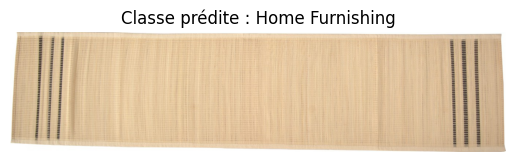

In [18]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Concatenate, Input, Embedding, LSTM, GlobalAveragePooling2D
from tensorflow.keras.models import Model


# Chemin vers la nouvelle image
image_path = "/content/drive/MyDrive/Images_market/00cbbc837d340fa163d11e169fbdb952.jpg"

# Charger et prétraiter l'image
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0  # Normalisation entre 0 et 1
img_array = np.expand_dims(img_array, axis=0) # Ajouter une dimension pour le batch

# Texte d'entrée
text = "Un beau tapis beige"

# Prétraitement du texte (Tokenizer, padding, etc.)
text_sequence = tokenizer.texts_to_sequences([text])
text_padded = pad_sequences(text_sequence, maxlen=max_length, padding='post', truncating='post')

# Prédiction
prediction = multi_input_model.predict({"image_input": img_array, "text_input": text_padded})

# Obtenir l'index de la classe prédite
predicted_class_index = np.argmax(prediction)

# Obtenir le nom de la classe prédite à partir du mapping des labels
predicted_class_name = unique_labels[predicted_class_index]

# Afficher l'image et le nom de la classe
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.title("Classe prédite : " + predicted_class_name)
plt.show()
